In [10]:
import numpy as np
import pickle as pkl
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn   
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def load_data(path):
    with open(path, 'rb') as f:
        data = pkl.load(f)
    return data

# Load the data
Interaction_matrices = load_data('/Users/sanazkazeminia/Documents/Mass_Spec_project/Mass_Spec_ML_Project/binary_interaction_matrices_10binned.pkl')
spectral_data = load_data('/Users/sanazkazeminia/Documents/Mass_Spec_project/Mass_Spec_ML_Project/binary_spectra_dataset_10binned.pkl')

print(Interaction_matrices.shape)
print(spectral_data.shape)

cpu
torch.Size([100000, 6, 6])
torch.Size([100000, 2001])


In [11]:
spectral_data = spectral_data.clone().detach().to(device)

torch.Size([100000, 2001])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2134e-35, 3.8346e-36,
        1.1643e-36])


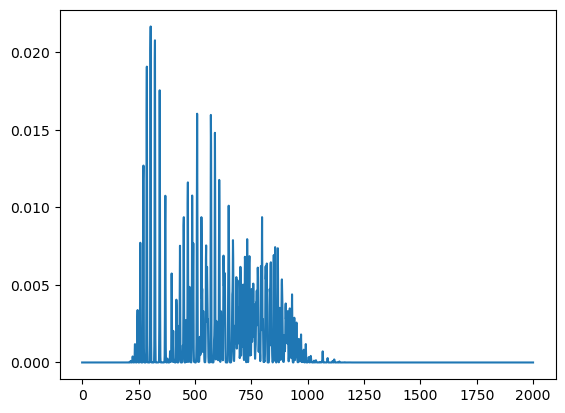

In [14]:
import matplotlib.pyplot as plt

print(spectral_data.shape)
print(spectral_data[0])

plt.plot(spectral_data[0])
plt.show()

In [55]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, neurons, latent_size, input): # neurons is a list of the number of neurons in each layer
        super(Autoencoder, self).__init__()

        # Encoder
        encoder_layers = []
        input_size = input
        for n in neurons:
            encoder_layers.append(nn.Linear(input_size, n))
            encoder_layers.append(nn.ReLU())
            input_size = n
        encoder_layers.append(nn.Linear(input_size, latent_size))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        input_size = latent_size
        for n in reversed(neurons):
            decoder_layers.append(nn.Linear(input_size, n))
            decoder_layers.append(nn.ReLU())
            input_size = n
        decoder_layers.append(nn.Linear(input_size, input))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [76]:
neurons = 512, 256, 128
latent_size = 64
input = 2001

model = Autoencoder(neurons, latent_size, input)
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [77]:
X_train, X_test = train_test_split(spectral_data, test_size=0.2, random_state=42)
X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=42)

In [78]:
import torch 
from torch.utils.data import DataLoader, TensorDataset


batch_size = 256 ## 512 is a good number for now. ?? 256 also worked well.

train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [79]:
print(X_train.type())

for data in train_loader:
    print(data[0].type())
    break

torch.FloatTensor
torch.FloatTensor


In [80]:
import wandb
num_epochs = 120

wandb.init(project='autoencoder',
           config={
               'neurons': neurons,
               'latent_size': latent_size,
               'input': input,
               'batch_size': batch_size,
               'num_epochs': num_epochs,
                'optimizer': 'Adam',
                'learning_rate': 0.0002

           })



for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0].to(device)
        output = model(data)
        loss = criteria(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    for data in val_loader:
        data = data[0].to(device)
        output = model(data)
        loss = criteria(output, data)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    torch.save(model.state_dict(), 'autoencoder.pth')
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
    
    wandb.log({'train_loss': train_loss, 'val_loss': val_loss})
    wandb.finish()
    
    print('Model saved')




Epoch 1/120, Train Loss: 1.054966075074548e-05, Val Loss: 3.7328843575323845e-06
Model saved
Epoch 2/120, Train Loss: 3.723259702621345e-06, Val Loss: 3.734005446176525e-06
Model saved
Epoch 3/120, Train Loss: 3.724689859794012e-06, Val Loss: 3.734314213943435e-06
Model saved
Epoch 4/120, Train Loss: 3.725834643390294e-06, Val Loss: 3.7343991550642388e-06
Model saved
Epoch 5/120, Train Loss: 3.7267938152447673e-06, Val Loss: 3.7342673181228746e-06
Model saved
Epoch 6/120, Train Loss: 3.7275294642476106e-06, Val Loss: 3.7340116477935227e-06
Model saved
Epoch 7/120, Train Loss: 3.7281285285033913e-06, Val Loss: 3.7340183894229996e-06
Model saved
Epoch 8/120, Train Loss: 3.7283625788288376e-06, Val Loss: 3.7331814553454025e-06
Model saved
Epoch 9/120, Train Loss: 3.7282685906874644e-06, Val Loss: 3.73208151813742e-06
Model saved
Epoch 10/120, Train Loss: 3.7263185926401556e-06, Val Loss: 3.725851649960532e-06
Model saved
Epoch 11/120, Train Loss: 3.4580374465705405e-06, Val Loss: 2.016966

In [81]:
with torch.no_grad():
    model.eval()
    test_loss = 0.0
    for data in test_loader:
        data = data[0].to(device)
        output = model(data)
        loss = criteria(output, data)
        test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f'Test Loss: {test_loss}')

Test Loss: 8.897872589841427e-07


In [82]:
with torch.no_grad():
    encoded = model.encoder(spectral_data) 
    decoded = model.decoder(encoded)
    mse = criteria(decoded, spectral_data).item()
    print(f'MSE: {mse}')



MSE: 8.87892667833512e-07


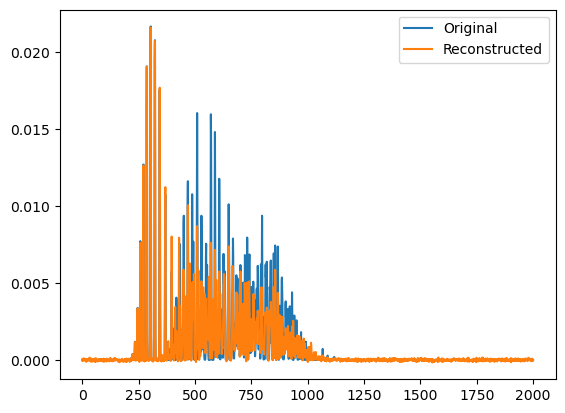

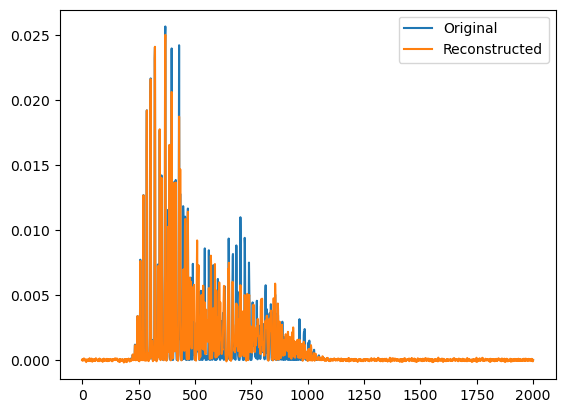

In [83]:
import matplotlib.pyplot as plt

plt.plot(spectral_data[0].cpu().numpy(), label='Original')
plt.plot(decoded[0].cpu().numpy(), label='Reconstructed')
plt.legend()
plt.show()

plt.plot(spectral_data[90].cpu().numpy(), label='Original')
plt.plot(decoded[90].cpu().numpy(), label='Reconstructed')
plt.legend()
plt.show()